## Import the libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditya.baser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the dataset

In [4]:
df = pd.read_csv('combined_csv_wealthmanagement.csv')
df.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,12/31/2019 23:45,HT_Great_Lakes,NaN,0,1,1,Thinking about transitioning your business? Yo...,NaN,NaN,#wealthmanagement #hightowergreatlakes #busine...,1.212160e+18,https://twitter.com/HT_Great_Lakes/status/1212...
1,12/31/2019 23:31,ripsawwealth,NaN,0,2,3,http://RipsawWealth.com #2020WillBeTheYearFor ...,NaN,NaN,#2020WillBeTheYearFor #HappyNewYear #happynewy...,1.212150e+18,https://twitter.com/ripsawwealth/status/121215...
2,12/31/2019 23:00,TedHunter1,NaN,0,0,0,#wealthmanagement #maxous,NaN,NaN,#wealthmanagement #maxous,1.212150e+18,https://twitter.com/TedHunter1/status/12121465...
3,12/31/2019 22:45,RAlexJimenez,NaN,0,0,0,#WealthManagement and private banking trends: ...,NaN,@FinTechMagazine,#WealthManagement #wealthtech #fintech #finserv,1.212140e+18,https://twitter.com/RAlexJimenez/status/121214...
4,12/31/2019 22:43,findadvisor,NaN,0,0,0,Is Your Money Ready for Retirement? #Retiremen...,NaN,NaN,#RetirementPlan #FinancialPlan #WealthManageme...,1.212140e+18,https://twitter.com/findadvisor/status/1212142...


## Factoring in the number of retweets and weighing tweets accordingly

In [5]:
df_tweets = df[["date","text","retweets"]]
df_tweets = df_tweets.dropna()
l1= df_tweets["text"].values
for i in range(len(l1)):
    l1[i] = (l1[i]+' ')*(int(df_tweets["retweets"].values[i]+1))
df_tweets["text"] =  l1
df_tweets = df_tweets[["date","text"]]
df_tweets.head()

,date,text
0,12/31/2019 23:45,Thinking about transitioning your business? Yo...
1,12/31/2019 23:31,http://RipsawWealth.com #2020WillBeTheYearFor ...
2,12/31/2019 23:00,#wealthmanagement #maxous
3,12/31/2019 22:45,#WealthManagement and private banking trends: ...
4,12/31/2019 22:43,Is Your Money Ready for Retirement? #Retiremen...


## Cleaning and tokenizing the data

In [56]:
def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='date'
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = stopwords.words('english')
    extended_words = ['&amp;', 'rt','th','co', 're', 've', 'kim', 'daca', '#wealthmanagement', 'wealthmanagement', 'de', 'la', 'en', 'day', 'di', 'el', 'ask', 'un', 'con', 'per', 'del', 'help', 'you', 'via', 'us', 'gt', 'ai', 'cx', 'you', 'time', 'make', 'get', 'one', 'uk']
    en_stop_words.extend(extended_words)
    en_stop_words = set(en_stop_words)
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word.strip() for word in row.split() if (not word.strip() in en_stop_words) and (not re.match(url_re, word.strip()))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean

,date,text,preprocessed_text,tokenized_text
0,12/31/2019 23:45,Thinking about transitioning your business? Yo...,thinking transitioning business? you’ll surpri...,"[thinking, transitioning, business, you, ll, s..."
1,12/31/2019 23:31,http://RipsawWealth.com #2020WillBeTheYearFor ...,#2020willbetheyearfor financial control! #happ...,"[willbetheyearfor, financial, control, happyne..."
2,12/31/2019 23:00,#wealthmanagement #maxous,#maxous,[maxous]
3,12/31/2019 22:45,#WealthManagement and private banking trends: ...,private banking trends: 2020 | @fintechmagazin...,"[private, banking, trends, fintechmagazine, we..."
4,12/31/2019 22:43,Is Your Money Ready for Retirement? #Retiremen...,money ready retirement? #retirementplan #finan...,"[money, ready, retirement, retirementplan, fin..."
...,...,...,...,...
26951,3/19/2019 17:11,.@Praemium said its major technology upgrade w...,.@praemium said major technology upgrade expan...,"[praemium, said, major, technology, upgrade, e..."
26952,3/19/2019 16:59,A Seismic Shift in the Estate-Planning Landsca...,seismic shift estate-planning landscape #estat...,"[seismic, shift, estate, planning, landscape, ..."
26953,3/19/2019 16:58,"Interview: Scott Cooper, @CybiWealth – investi...","interview: scott cooper, @cybiwealth – investi...","[interview, scott, cooper, cybiwealth, investi..."
26954,3/19/2019 16:18,How much are you worth? . . . . #wealth #Wealt...,much worth? . . . . #wealth #wealthy #wealthbu...,"[much, worth, wealth, wealthy, wealthbuilding,..."


## Most frequent words

In [7]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('wealth', 9035),
 ('investing', 5677),
 ('financialplanning', 4843),
 ('investment', 4549),
 ('fintech', 4428),
 ('financial', 4288),
 ('money', 3916),
 ('retirement', 3600),
 ('finance', 3435),
 ('management', 3323)]

In [8]:
# build a dictionary where for each tweet, each word has its own id.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

## Do not Run the below Cell - Takes 45 mins to run

In [8]:
# compute coherence
tweets_coherence = []
for nb_topics in range(1,25):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

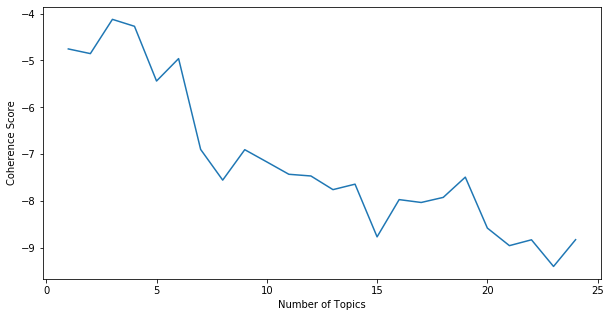

In [9]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,25),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [30]:
k = 10
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

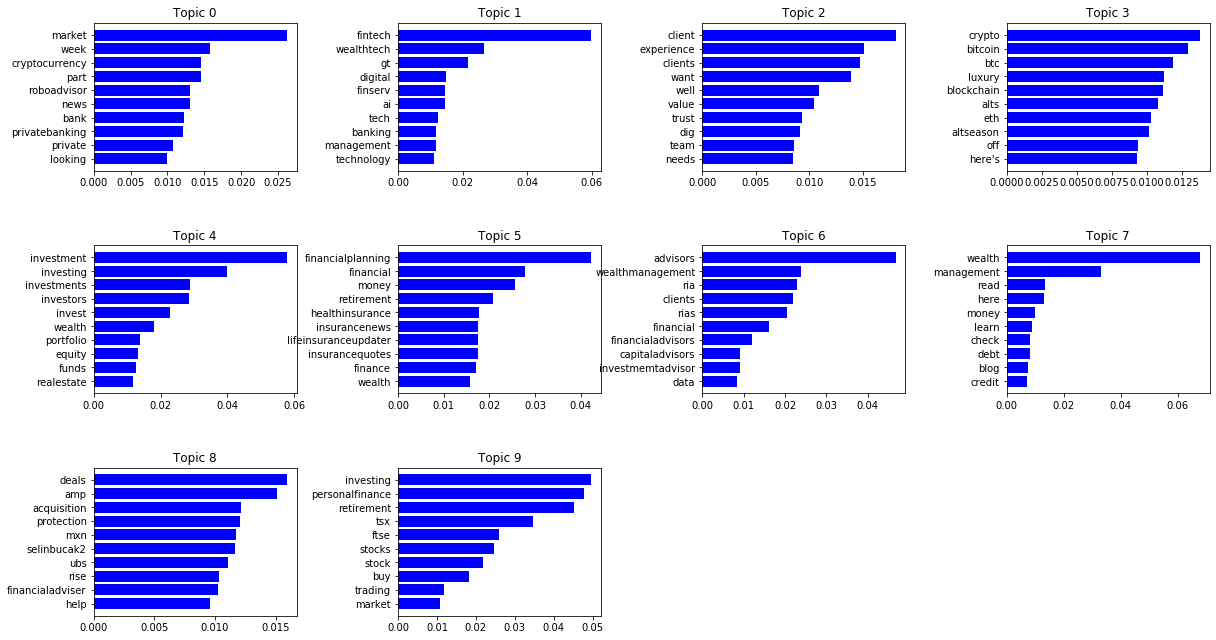

In [31]:
import matplotlib.gridspec as gridspec
plot_top_words()

In [32]:
list1 = []
list2 = []
for i in range(len(df_tweets_clean)):
    x = tweets_lda[tweets_corpus[i]]
    x.sort(key=lambda x:x[1], reverse = True)
    list1.append('Topic'+str(x[0][0]))
    try:
        if x[1][1] > 0.25:
            list2.append('Topic'+str(x[1][0]))
        else: 
            list2.append(None)
    except: 
            list2.append(None)

In [33]:
df_tweets_clean["Label1"] = list1
df_tweets_clean["Label2"] = list2
df_tweets_clean

,date,text,preprocessed_text,tokenized_text,Label1,Label2
0,12/31/2019 23:45,Thinking about transitioning your business? Yo...,thinking transitioning business? you’ll surpri...,"[thinking, transitioning, business, you, ll, s...",Topic5,None
1,12/31/2019 23:31,http://RipsawWealth.com #2020WillBeTheYearFor ...,#2020willbetheyearfor financial control! #happ...,"[willbetheyearfor, financial, control, happyne...",Topic5,Topic6
2,12/31/2019 23:00,#wealthmanagement #maxous,#maxous,[maxous],Topic8,None
3,12/31/2019 22:45,#WealthManagement and private banking trends: ...,private banking trends: 2020 | @fintechmagazin...,"[private, banking, trends, fintechmagazine, we...",Topic1,None
4,12/31/2019 22:43,Is Your Money Ready for Retirement? #Retiremen...,money ready retirement? #retirementplan #finan...,"[money, ready, retirement, retirementplan, fin...",Topic5,None
...,...,...,...,...,...,...
26951,3/19/2019 17:11,.@Praemium said its major technology upgrade w...,.@praemium said major technology upgrade expan...,"[praemium, said, major, technology, upgrade, e...",Topic1,None
26952,3/19/2019 16:59,A Seismic Shift in the Estate-Planning Landsca...,seismic shift estate-planning landscape #estat...,"[seismic, shift, estate, planning, landscape, ...",Topic5,Topic6
26953,3/19/2019 16:58,"Interview: Scott Cooper, @CybiWealth – investi...","interview: scott cooper, @cybiwealth – investi...","[interview, scott, cooper, cybiwealth, investi...",Topic1,Topic0
26954,3/19/2019 16:18,How much are you worth? . . . . #wealth #Wealt...,much worth? . . . . #wealth #wealthy #wealthbu...,"[much, worth, wealth, wealthy, wealthbuilding,...",Topic7,None


In [38]:
df = df.dropna(subset = ["text"])
df

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,12/31/2019 23:45,HT_Great_Lakes,NaN,0,1,1,Thinking about transitioning your business? Yo...,NaN,NaN,#wealthmanagement #hightowergreatlakes #busine...,1.212160e+18,https://twitter.com/HT_Great_Lakes/status/1212...
1,12/31/2019 23:31,ripsawwealth,NaN,0,2,3,http://RipsawWealth.com #2020WillBeTheYearFor ...,NaN,NaN,#2020WillBeTheYearFor #HappyNewYear #happynewy...,1.212150e+18,https://twitter.com/ripsawwealth/status/121215...
2,12/31/2019 23:00,TedHunter1,NaN,0,0,0,#wealthmanagement #maxous,NaN,NaN,#wealthmanagement #maxous,1.212150e+18,https://twitter.com/TedHunter1/status/12121465...
3,12/31/2019 22:45,RAlexJimenez,NaN,0,0,0,#WealthManagement and private banking trends: ...,NaN,@FinTechMagazine,#WealthManagement #wealthtech #fintech #finserv,1.212140e+18,https://twitter.com/RAlexJimenez/status/121214...
4,12/31/2019 22:43,findadvisor,NaN,0,0,0,Is Your Money Ready for Retirement? #Retiremen...,NaN,NaN,#RetirementPlan #FinancialPlan #WealthManageme...,1.212140e+18,https://twitter.com/findadvisor/status/1212142...
...,...,...,...,...,...,...,...,...,...,...,...,...
26951,3/19/2019 17:11,haiyencutelam,NaN,0,0,0,.@Praemium said its major technology upgrade w...,NaN,NaN,#Exchanges #Explained #healthinsurance #insura...,1.108050e+18,https://twitter.com/haiyencutelam/status/11080...
26952,3/19/2019 16:59,FFPWealthMgt,NaN,0,0,0,A Seismic Shift in the Estate-Planning Landsca...,NaN,NaN,#WealthManagement #economicUpdate #FinancialAd...,1.108050e+18,https://twitter.com/FFPWealthMgt/status/110805...
26953,3/19/2019 16:58,PaulBeachAL,NaN,0,0,0,"Interview: Scott Cooper, @CybiWealth – investi...",NaN,NaN,#winner #inspiringinnovator #wealthmanagement ...,1.108050e+18,https://twitter.com/PaulBeachAL/status/1108050...
26954,3/19/2019 16:18,danwoodruff,NaN,0,0,1,How much are you worth? . . . . #wealth #Wealt...,NaN,NaN,#FinancialPlanning #WealthManagement #Inherita...,1.108040e+18,https://twitter.com/danwoodruff/status/1108039...


In [45]:
df_tweets_merge = df_tweets_clean.join(df, lsuffix = ["date", "text"], rsuffix = ["date", "text"])
df_tweets_merge = df_tweets_merge.loc[:,~df_tweets_merge.columns.duplicated()]
df_tweets_merge = df_tweets_merge.rename(columns = {"date['date', 'text']":"date", "text['date', 'text']": "text"})
df_tweets_merge.to_csv("labeled_data_wealthmanagement.csv")

In [52]:
documents = list(df_tweets_clean["preprocessed_text"])

In [62]:
import gensim
list_tfidf = []
tfidf = gensim.models.TfidfModel(tweets_corpus)
for doc in tfidf[tweets_corpus]:
    list_tfidf.append([[tweets_dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

In [71]:
list_tfidf[0][1][0]

'business'

In [73]:
list_1 = []
list_3 = []
for i in range(len(list_tfidf)):
    list_2 = []
    list_4 = []
    for j in range(len(list_tfidf[i])):
        list_2.append(list_tfidf[i][j][0])
        list_4.append(list_tfidf[i][j][1])
    list_1.append(list_2)
    list_3.append(list_4)   

In [79]:
tfidf_df = pd.DataFrame({"Tweets":list_1, "tfidf_score":list_3})
tfidf_df.to_csv("tfidf.csv")

In [42]:
list_1 = []
list_2 = []
for i in range(len(weighted_phrases)):
    list_1.append(weighted_phrases[i][0])
    list_2.append(weighted_phrases[i][1])

In [46]:
wphrases = pd.DataFrame({"Phrases":list_1, "Score":list_2})

In [47]:
wphrases

,Phrases,Score
0,maxous,1.000
1,financialadvisors,1.000
2,increasewealth,1.000
3,axaexclusiv,1.000
4,ripsawwealth,1.000
...,...,...
41030,clients,0.099
41031,top,0.095
41032,management,0.089
41033,private,0.073
